# Spotify Song Prediction

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Dependencies

In [5]:
# Ucitavanje biblioteka i funkcija
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

##### Util classes

In [6]:
class ModelResultsLogger:
    def __init__(self):
        self.model_scores = {}

    def log_score(self, model_name, dataset_name, r2_score):
        if model_name not in self.model_scores:
            self.model_scores[model_name] = {}
        self.model_scores[model_name][dataset_name] = r2_score

    def plot_results(self):
        models = list(self.model_scores.keys())
        datasets = list(next(iter(self.model_scores.values())).keys())

        fig, ax = plt.subplots()
        bar_width = 0.35
        index = range(len(models))

        for i, dataset_name in enumerate(datasets):
            scores = [self.model_scores[model_name].get(dataset_name, None) for model_name in models]
            ax.bar([x + i * bar_width for x in index], scores, bar_width, label=dataset_name)

        ax.set_xlabel('Models')
        ax.set_ylabel('R2 Score')
        ax.set_title('Comparison of R2 Scores for Different Models and Datasets')
        ax.set_xticks([x + bar_width / 2 for x in index])
        ax.set_xticklabels(models)
        ax.legend()

        plt.show()

logger = ModelResultsLogger()

##### Loading the dataset

In [7]:
#New database: https://github.com/yashrajkakkad/song-popularity-prediction/tree/master
df = pd.read_csv('/content/drive/MyDrive/Datasets/spotify_songs.csv')
df_two = pd.read_csv('/content/drive/MyDrive/Datasets/data_merged.csv')


df.head()


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [8]:
df_two.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness',
       'tempo', 'valence', 'year', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'minor', 'major', 'acousticness_ar', 'danceability_ar',
       'duration_ms_ar', 'energy_ar', 'instrumentalness_ar', 'liveness_ar',
       'loudness_ar', 'speechiness_ar', 'tempo_ar', 'valence_ar',
       'popularity_ar', 'count', 'key_0_ar', 'key_1_ar', 'key_2_ar',
       'key_3_ar', 'key_4_ar', 'key_5_ar', 'key_6_ar', 'key_7_ar', 'key_8_ar',
       'key_9_ar', 'key_10_ar', 'key_11_ar', 'minor_ar', 'major_ar',
       'acousticness_yr', 'danceability_yr', 'duration_ms_yr', 'energy_yr',
       'instrumentalness_yr', 'liveness_yr', 'loudness_yr', 'speechiness_yr',
       'tempo_yr', 'valence_yr', 'popularity_yr', 'mode', 'key_0_yr',
       'key_1_yr', 'key_2_yr', 'key_3_yr', 'ke

##### Dropping invalid and missing values

In [9]:
columns_to_drop = ['track_id', 'track_artist', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id']
df.drop(columns=columns_to_drop, inplace=True)
df.dropna(axis=0, inplace=True)

# df = df[df['track_popularity'] < 15]

rows_to_drop = df.loc[df['duration_ms'] < 20000].index
df.drop(rows_to_drop, inplace=True)

new_df = df.copy()

# Assuming 'date' is a string column in the format 'YYYY-MM-DD'
new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# Convert the columns to numeric (to handle missing values during median calculation)
new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')
# new_df['month'] = pd.to_numeric(new_df['month'], errors='coerce', downcast='integer')
# new_df['day'] = pd.to_numeric(new_df['day'], errors='coerce', downcast='integer')

# Calculate median values for year, month, and day
median_year = int(new_df['year'].median())
# median_month = int(new_df['month'].median())
# median_day = int(new_df['day'].median())

# Fill missing values with median values
new_df['year'] = new_df['year'].fillna(median_year).astype(int)
# new_df['month'] = new_df['month'].fillna(median_month).astype(int)
# new_df['day'] = new_df['day'].fillna(median_day).astype(int)

X = new_df.drop(['track_popularity', 'track_album_release_date', 'month', 'day'], axis=1)
# X.columns

X = pd.get_dummies(X, dtype=int)
X['year'] = new_df['year']
y = new_df['track_popularity']

#New data set
X_two = df_two.drop(columns=['popularity'])
y_two = df_two['popularity']


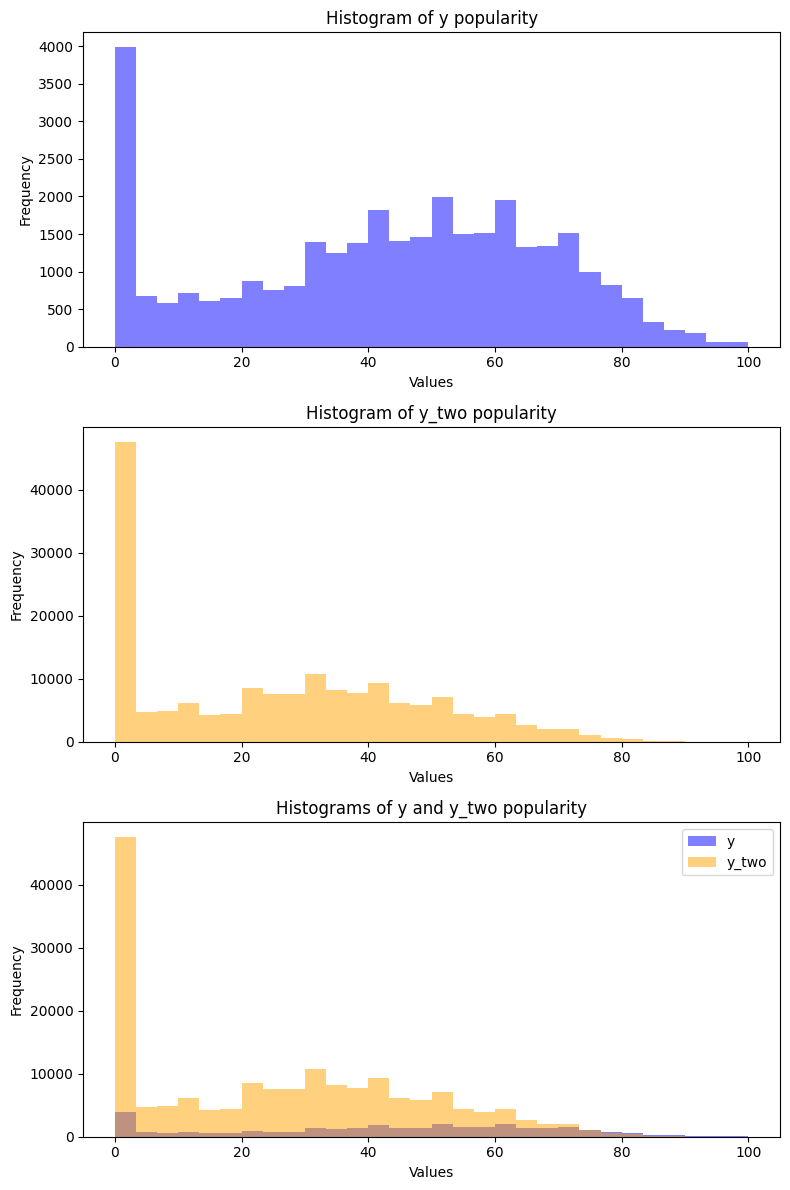

In [10]:


fig, axes = plt.subplots(3, 1, figsize=(8, 12))

axes[0].hist(y, bins=30, alpha=0.5, color='blue')
axes[0].set_title('Histogram of y popularity')

axes[1].hist(y_two, bins=30, alpha=0.5, color='orange')
axes[1].set_title('Histogram of y_two popularity')

axes[2].hist(y, bins=30, alpha=0.5, color='blue', label='y')
axes[2].hist(y_two, bins=30, alpha=0.5, color='orange', label='y_two')
axes[2].set_title('Histograms of y and y_two popularity')

axes[2].legend()

for ax in axes:
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# X.tail()
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'year', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subge

In [12]:
df.iloc[3446]
X.iloc[3446]

danceability                                        0.63000
energy                                              0.52600
key                                                 7.00000
loudness                                           -9.12100
mode                                                1.00000
speechiness                                         0.03890
acousticness                                        0.31600
instrumentalness                                    0.00538
liveness                                            0.07470
valence                                             0.61000
tempo                                             145.27100
duration_ms                                    215333.00000
year                                             1981.00000
playlist_genre_edm                                  0.00000
playlist_genre_latin                                0.00000
playlist_genre_pop                                  1.00000
playlist_genre_r&b                      

##### Splitting the dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_two, X_test_two, y_trian_two, y_test_two = train_test_split(X_two, y_two, test_size=0.1, random_state=42)

In [14]:
X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,playlist_subgenre_new jack swing,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary
count,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,...,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000
mean,0.654869,0.698631,5.374604,-6.718909,0.565698,0.107071,0.175339,0.084750,0.190182,0.510577,...,0.034509,0.033656,0.046205,0.034387,0.055099,0.028905,0.051017,0.039321,0.039230,0.042794
std,0.145043,0.180900,3.611632,2.986570,0.495673,0.101314,0.219634,0.224233,0.154316,0.233132,...,0.182535,0.180345,0.209932,0.182224,0.228176,0.167541,0.220036,0.194361,0.194145,0.202395
min,0.077100,0.000175,0.000000,-46.448000,0.000000,0.022400,0.000001,0.000000,0.009360,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
print(X.columns)

numeric_feats = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
dummy_feats = [feat for feat in X.columns if feat not in numeric_feats]

print(X[numeric_feats])

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'year', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subge

<Axes: >

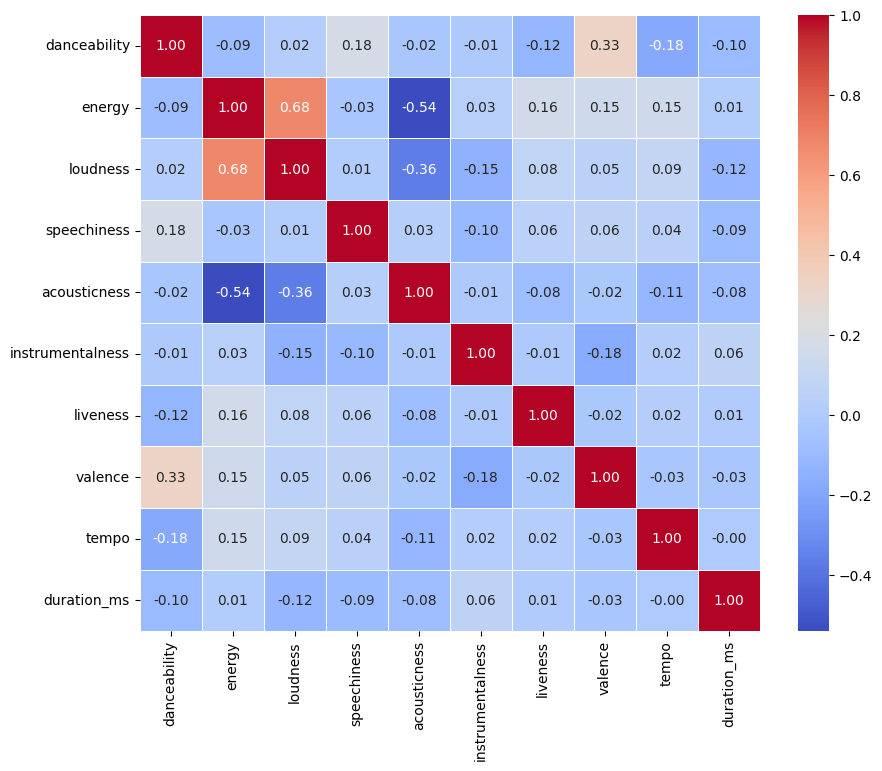

In [16]:
numeric_values = df[numeric_feats]
correlation_matrix = numeric_values.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [17]:
def model_evaluation(y_test, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1 - ((1 - r2) * (N - 1)) / (N - d - 1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res = pd.concat([pd.DataFrame(y_test.values),
                    pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return mse, mae, rmse, r2, r2_adj

##### Scaling the data

In [18]:
s = StandardScaler()

s.fit(X_train[numeric_feats])
X_train_std = s.transform(X_train[numeric_feats])
X_test_std = s.transform(X_test[numeric_feats])
X_train_std = pd.DataFrame(X_train_std)
X_test_std = pd.DataFrame(X_test_std)

X_train_std = pd.concat([X_train_std, X_train[dummy_feats].reset_index(drop=True)], axis=1)
X_test_std = pd.concat([X_test_std, X_test[dummy_feats].reset_index(drop=True)], axis=1)

X_train_std.columns = list(X.columns)
X_test_std.columns = list(X.columns)
X_train_std.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,playlist_subgenre_new jack swing,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary
0,0.622867,-2.212089,-0.307576,-0.709015,2.267368,-0.377976,0.650536,-0.878447,-0.964504,-0.112134,...,0,0,0,0,0,0,0,0,0,0
1,-2.670088,1.406350,0.609448,-0.110755,-0.786554,-0.377986,0.598812,0.245905,-1.334977,0.696852,...,0,0,0,0,0,0,0,0,0,0
2,-1.168280,-1.033607,-0.116544,-0.722836,-0.758601,-0.377986,-0.564964,-0.775453,0.931639,-0.146528,...,0,1,0,0,0,0,0,0,0,0
3,-1.154502,-1.481762,-1.237313,-0.816622,-0.432978,-0.350407,0.049251,-1.238926,-1.190485,-0.252741,...,0,0,0,0,0,0,0,0,0,0
4,-1.120057,0.875203,1.367222,-0.411859,-0.413888,-0.377952,0.993203,-0.505093,0.338086,-0.053085,...,0,0,1,0,0,0,0,0,0,0


In [19]:
s.fit(X_train_two)
X_train_two_std = s.transform(X_train_two)
X_test_two_std = s.transform(X_test_two)
X_train_two_std = pd.DataFrame(X_train_two_std)
X_test_two_std = pd.DataFrame(X_test_two_std)


### Linear Regression

#### Base LR

In [20]:
lrm = LinearRegression()

##### Data Set 1

In [21]:
# final model
n_features_optimal = 13

lrm.fit(X_train_std, y_train)

# predict prices of X_test
y_pred = lrm.predict(X_test_std)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("r2:", r2)
print("mse", mse)
logger.log_score('linearRegression', 'ds1', r2)

model_evaluation(y_test, y_pred, X_train_std.shape[0], X_train_std.shape[1])

r2: 0.16050973366795573
mse 510.10274155128855
Mean squared error:  510.10274155128855
Mean absolute error:  18.546015504277634
Root mean squared error:  22.585454202899896
R2 score:  0.16050973366795573
R2 adjusted score:  0.15928623578793
     y     y_pred
0   42  44.671188
1   64  54.739341
2   40  49.812058
3   41  15.868377
4   27  34.327000
5   55  55.063793
6    0  53.399918
7    0  47.685816
8   40  40.668121
9   50  36.865072
10   1  42.657903
11  32  52.633618
12  67  57.881479
13  63  32.957983
14  53  55.413670
15  42  37.947987
16  53  51.577610
17  80  41.101766
18  62  42.984560
19   2  47.289255


(510.10274155128855,
 18.546015504277634,
 22.585454202899896,
 0.16050973366795573,
 0.15928623578793)

##### Data Set 2

In [22]:

lrm.fit(X_train_two, y_trian_two)

# predict prices of X_test
y_pred_two = lrm.predict(X_test_two)
r2 = r2_score(y_test_two, y_pred_two)
mse = mean_squared_error(y_test_two, y_pred_two)
print("r2:", r2)
print("mse", mse)
logger.log_score('linearRegression', 'ds2', r2)

model_evaluation(y_test_two, y_pred_two, X_train_two.shape[0], X_train_two.shape[1])

r2: 0.8305965198606206
mse 80.56216267303232
Mean squared error:  80.56216267303232
Mean absolute error:  6.20091473819242
Root mean squared error:  8.975642744284796
R2 score:  0.8305965198606206
R2 adjusted score:  0.8305188895828273
     y     y_pred
0   25  15.495005
1   53  54.723206
2   65  57.776980
3   16  28.511850
4   14  17.916959
5   19  27.322598
6    0   1.095436
7    0  -4.636695
8   49  49.267128
9    6  10.813405
10  67  47.466215
11  59  49.696927
12  45  42.178026
13  26  31.767818
14  74  64.693783
15  31  33.676331
16   0   4.423023
17  54  49.743412
18  16  20.739295
19  26  27.001657


(80.56216267303232,
 6.20091473819242,
 8.975642744284796,
 0.8305965198606206,
 0.8305188895828273)

#### Base Lasso

In [23]:
lm = Lasso(alpha=0.01)

##### Data set 1

Mean squared error:  510.2116433335174
Mean absolute error:  18.56364359470541
Root mean squared error:  22.587864957395094
R2 score:  0.16033051097668127
R2 adjusted score:  0.15910675189221812
     y     y_pred
0   42  44.768687
1   64  54.365374
2   40  50.022237
3   41  15.717831
4   27  34.570250
5   55  54.772381
6    0  53.061137
7    0  47.698221
8   40  40.914494
9   50  37.118091
10   1  42.778128
11  32  52.450107
12  67  57.651556
13  63  33.204621
14  53  55.091663
15  42  37.976913
16  53  51.331273
17  80  41.200967
18  62  43.188454
19   2  46.984588
koeficijenti:  [ 1.42960626e+00 -4.62617441e+00  4.20093757e+00  2.17060486e-03
  1.47393465e-01 -2.18879770e+00 -2.80137726e-01 -5.37369284e-01
  3.38325771e-01 -1.70059068e+00  4.31390079e-02  6.34029601e-02
 -9.69055311e-02 -3.85840079e+00  6.28472562e-01  1.03147025e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.83135298e+00
 -3.22399921e+00  0.00000000e+00  7.47300394e+00 -0.00000000e+00
 -0.00000000e+00 -9.72

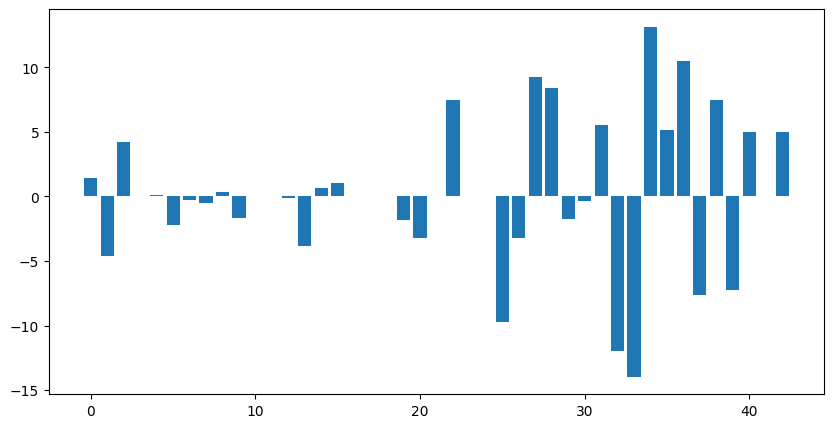

In [24]:

#Obuka
lm.fit(X_train_std, y_train)

# Testiranje
y_predicted = lm.predict(X_test_std)

# Evaluacija (racunanje mera uspesnosti)
_, _, _, r2, _ = model_evaluation(y_test, y_predicted, X_train_std.shape[0], X_train_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lm.coef_)),lm.coef_)
print("koeficijenti: ", lm.coef_)
logger.log_score('Lasso', 'ds1', r2)

##### Data set 2

Mean squared error:  80.61852439576401
Mean absolute error:  6.196800399307553
Root mean squared error:  8.978781899331558
R2 score:  0.830478004273891
R2 adjusted score:  0.8304003196855374
     y     y_pred
0   25  15.506779
1   53  54.794656
2   65  58.492307
3   16  28.372378
4   14  17.953314
5   19  27.533737
6    0   1.076936
7    0  -4.616739
8   49  49.374612
9    6  10.948752
10  67  47.593155
11  59  49.620419
12  45  42.287618
13  26  31.581366
14  74  64.509387
15  31  33.742425
16   0   4.576662
17  54  49.689255
18  16  20.792983
19  26  27.308515
koeficijenti:  [-3.34446685e-01  6.00018796e-01  1.92522268e-01 -5.11388066e-03
  1.66263139e-01 -1.92608450e-01 -5.46303319e-01  2.42157649e-01
 -8.55480460e-01  3.44488406e-02 -2.13092320e-02 -1.00312700e+00
  0.00000000e+00  8.26793812e-02 -3.35477462e-02  0.00000000e+00
  2.32804476e-02 -1.59629158e-02  6.64662646e-02 -3.53749679e-02
  6.97424642e-02 -3.60463379e-02 -0.00000000e+00  2.14182754e-02
  1.04106460e-01 -1.980261

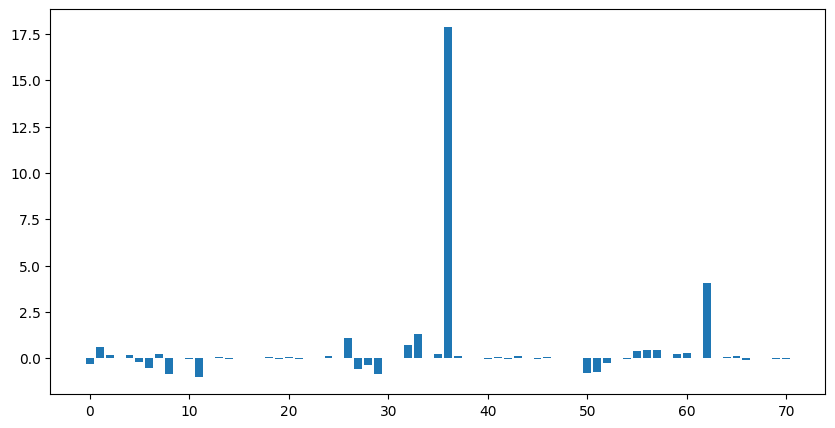

In [25]:
#Obuka
lm.fit(X_train_two_std, y_trian_two)

# Testiranje
y_predicted = lm.predict(X_test_two_std)

# Evaluacija (racunanje mera uspesnosti)
_, _, _, r2, _ = model_evaluation(y_test_two, y_predicted, X_train_two_std.shape[0], X_train_two_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lm.coef_)),lm.coef_)
print("koeficijenti: ", lm.coef_)
logger.log_score('Lasso', 'ds2', r2)

#### Base Ridge

In [26]:
# Inicijalizacija modela
rm = Ridge(alpha=5)

##### Data set 1

Mean squared error:  510.1068153746893
Mean absolute error:  18.54804109906502
Root mean squared error:  22.585544389602152
R2 score:  0.16050302926350324
R2 adjusted score:  0.15927952161228076
     y     y_pred
0   42  44.693492
1   64  54.705572
2   40  49.837418
3   41  15.845621
4   27  34.362447
5   55  55.027622
6    0  53.360042
7    0  47.697301
8   40  40.696473
9   50  36.906278
10   1  42.672334
11  32  52.629879
12  67  57.834769
13  63  32.994708
14  53  55.375258
15  42  37.950949
16  53  51.563278
17  80  41.120981
18  62  43.008016
19   2  47.267126
koeficijenti:  [  1.43693279  -4.6204916    4.21292717   0.0275944    0.13356412
  -2.18468913  -0.27951864  -0.57978009   0.34333053  -1.68639856
   0.0457702    0.10082384  -0.10449161  -4.51697415   2.90337776
   3.91089463  -2.75523226  -0.78368897   1.24162298  -3.80370819
  -3.13475794  -1.65182567   4.55824916   0.36307549  -3.17437462
  -9.48769806  -5.0578526    9.96450127  11.0781087   -5.0570037
  -3.11284905   3

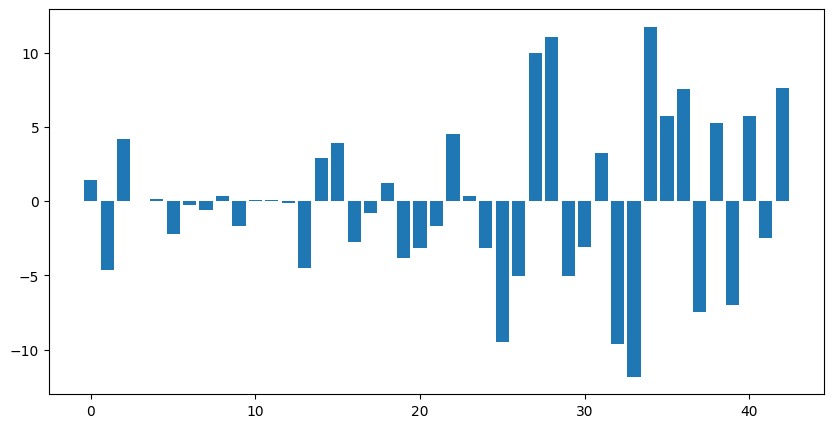

In [27]:
#Obuka
rm.fit(X_train_std, y_train)

# Testiranje
y_predicted = rm.predict(X_test_std)

# Evaluacija (racunanje mera uspesnosti)
_, _, _, r2, _ = model_evaluation(y_test, y_predicted, X_train_std.shape[0], X_train_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)
logger.log_score('Ridge', 'ds1', r2)

##### Data set 2

Mean squared error:  80.56224794050348
Mean absolute error:  6.20094575112632
Root mean squared error:  8.975647494220318
R2 score:  0.8305963405629716
R2 adjusted score:  0.830518710203014
     y     y_pred
0   25  15.495593
1   53  54.721856
2   65  57.777322
3   16  28.512100
4   14  17.916504
5   19  27.323396
6    0   1.095960
7    0  -4.636280
8   49  49.266773
9    6  10.814883
10  67  47.465471
11  59  49.695891
12  45  42.178523
13  26  31.768267
14  74  64.692157
15  31  33.675660
16   0   4.425989
17  54  49.742286
18  16  20.740026
19  26  27.002146
koeficijenti:  [-4.35782102e-01  6.89179513e-01  2.20638660e-01 -1.18135261e-02
  1.75486740e-01 -2.53158375e-01 -5.57712845e-01  2.30738109e-01
 -1.03474264e+00  6.05102793e-02 -9.92636278e-02 -1.44581624e+00
 -1.19168946e-02  8.57546849e-02 -4.86020419e-02 -2.63572244e-03
  2.71427946e-02 -3.80580896e-02  6.82014565e-02 -5.15732220e-02
  7.03983286e-02 -5.25176376e-02 -1.99781986e-02  2.63731621e-02
  5.84304951e-02 -5.8430495

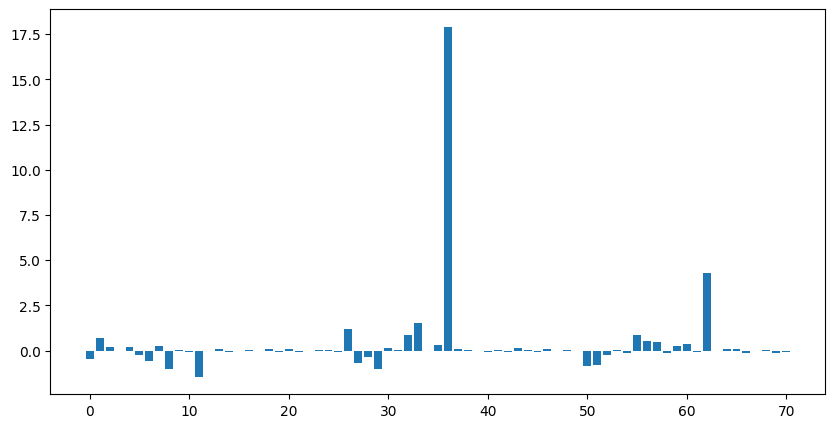

In [28]:
#Obuka
rm.fit(X_train_two_std, y_trian_two)

# Testiranje
y_predicted = rm.predict(X_test_two_std)

# Evaluacija (racunanje mera uspesnosti)
_, _, _, r2, _ = model_evaluation(y_test_two, y_predicted, X_train_two_std.shape[0], X_train_two_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)
logger.log_score('Ridge', 'ds2', r2)

##### Poly hypothesis

In [29]:
poly = PolynomialFeatures(interaction_only=False, degree=2, include_bias=True)
poly_two = PolynomialFeatures(interaction_only=False, degree=2, include_bias=True)

X_inter_train = poly.fit_transform(X_train_std)
X_inter_test = poly.transform(X_test_std)

X_inter_two_train = poly_two.fit_transform(X_train_two_std)
X_inter_two_test = poly_two.transform(X_test_two_std)

out_feat_names = PolynomialFeatures.get_feature_names_out(
    poly, input_features=None)

out_feat_names_two = PolynomialFeatures.get_feature_names_out(
    poly_two, input_features=None)

#### LR Poly

In [30]:
# final model
lrm = LinearRegression()

##### Data set 1

In [31]:

lrm.fit(X_inter_train, y_train)

# predict prices of X_test
y_pred = lrm.predict(X_inter_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("r2:", r2)
print("mse", mse)
logger.log_score('LR Poly', 'ds1', r2)

model_evaluation(y_test, y_pred, X_train_std.shape[0], X_train_std.shape[1])

r2: 0.21112255740779806
mse 479.3486742526286
Mean squared error:  479.3486742526286
Mean absolute error:  17.899233574990895
Root mean squared error:  21.89403284579222
R2 score:  0.21112255740779806
R2 adjusted score:  0.2099728241502241
     y     y_pred
0   42  42.261382
1   64  34.365103
2   40  50.511320
3   41  20.101680
4   27  28.892728
5   55  52.689849
6    0  44.882106
7    0  46.287224
8   40  34.251374
9   50  42.642079
10   1  28.571129
11  32  50.595832
12  67  66.612692
13  63  39.241586
14  53  53.864131
15  42  38.935900
16  53  53.418883
17  80  34.379358
18  62  41.433683
19   2  38.082533


(479.3486742526286,
 17.899233574990895,
 21.89403284579222,
 0.21112255740779806,
 0.2099728241502241)

##### Data set 2

In [32]:

lrm.fit(X_inter_two_train, y_trian_two)

# predict prices of X_test
y_pred = lrm.predict(X_inter_two_test)
r2 = r2_score(y_test_two, y_pred_two)
mse = mean_squared_error(y_test_two, y_pred_two)
print("r2:", r2)
print("mse", mse)
logger.log_score('LR Poly', 'ds2', r2)

model_evaluation(y_test_two, y_pred_two, X_train_two_std.shape[0], X_train_two_std.shape[1])

r2: 0.8305965198606206
mse 80.56216267303232
Mean squared error:  80.56216267303232
Mean absolute error:  6.20091473819242
Root mean squared error:  8.975642744284796
R2 score:  0.8305965198606206
R2 adjusted score:  0.8305188895828273
     y     y_pred
0   25  15.495005
1   53  54.723206
2   65  57.776980
3   16  28.511850
4   14  17.916959
5   19  27.322598
6    0   1.095436
7    0  -4.636695
8   49  49.267128
9    6  10.813405
10  67  47.466215
11  59  49.696927
12  45  42.178026
13  26  31.767818
14  74  64.693783
15  31  33.676331
16   0   4.423023
17  54  49.743412
18  16  20.739295
19  26  27.001657


(80.56216267303232,
 6.20091473819242,
 8.975642744284796,
 0.8305965198606206,
 0.8305188895828273)

#### Lasso Poly

In [33]:
# Define hyperparameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

# Instantiate Lasso regression model
lasso = Lasso()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

##### Data set 1

Mean squared error:  510.10846123955525
Mean absolute error:  18.547680176178584
Root mean squared error:  22.585580825817946
R2 score:  0.1605003206179264
R2 adjusted score:  0.15927680901904395
     y     y_pred
0   42  44.680945
1   64  54.701956
2   40  49.833075
3   41  15.853353
4   27  34.351338
5   55  55.034645
6    0  53.366054
7    0  47.687072
8   40  40.692744
9   50  36.890346
10   1  42.669775
11  32  52.615272
12  67  57.858480
13  63  32.982639
14  53  55.381477
15  42  37.950924
16  53  51.552974
17  80  41.111694
18  62  43.004950
19   2  47.258814
koeficijenti:  [-4.35782102e-01  6.89179513e-01  2.20638660e-01 -1.18135261e-02
  1.75486740e-01 -2.53158375e-01 -5.57712845e-01  2.30738109e-01
 -1.03474264e+00  6.05102793e-02 -9.92636278e-02 -1.44581624e+00
 -1.19168946e-02  8.57546849e-02 -4.86020419e-02 -2.63572244e-03
  2.71427946e-02 -3.80580896e-02  6.82014565e-02 -5.15732220e-02
  7.03983286e-02 -5.25176376e-02 -1.99781986e-02  2.63731621e-02
  5.84304951e-02 -5.8

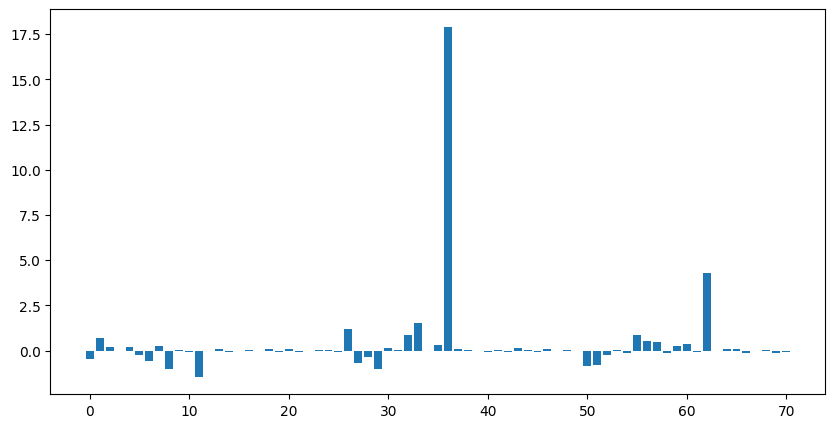

In [34]:
# Fit grid search to training data
grid_search.fit(X_train_std, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

model_evaluation(y_test, y_pred, X_train_std.shape[0], X_train_std.shape[1])

# Ilustracija koeficijenata
logger.log_score('Lasso Poly', 'ds1', r2)
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)

##### Data set 2

Mean squared error:  80.56687123383686
Mean absolute error:  6.200305630292244
Root mean squared error:  8.975905037033138
R2 score:  0.8305866188529977
R2 adjusted score:  0.8305089840380014
     y     y_pred
0   25  15.485879
1   53  54.735461
2   65  57.846214
3   16  28.507467
4   14  17.917747
5   19  27.345627
6    0   1.098210
7    0  -4.625778
8   49  49.285756
9    6  10.827624
10  67  47.482470
11  59  49.692665
12  45  42.194202
13  26  31.760340
14  74  64.668902
15  31  33.668940
16   0   4.456522
17  54  49.735401
18  16  20.743637
19  26  27.031325
koeficijenti:  [-4.35782102e-01  6.89179513e-01  2.20638660e-01 -1.18135261e-02
  1.75486740e-01 -2.53158375e-01 -5.57712845e-01  2.30738109e-01
 -1.03474264e+00  6.05102793e-02 -9.92636278e-02 -1.44581624e+00
 -1.19168946e-02  8.57546849e-02 -4.86020419e-02 -2.63572244e-03
  2.71427946e-02 -3.80580896e-02  6.82014565e-02 -5.15732220e-02
  7.03983286e-02 -5.25176376e-02 -1.99781986e-02  2.63731621e-02
  5.84304951e-02 -5.84304

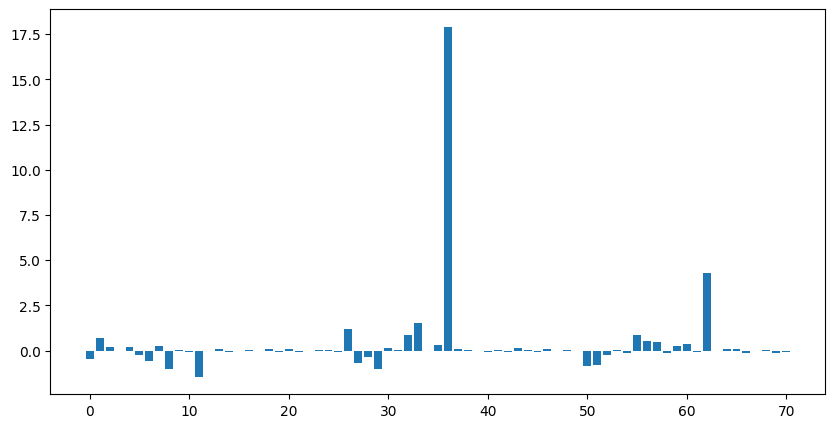

In [35]:
# Fit grid search to training data
grid_search.fit(X_train_two_std, y_trian_two)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_two_std)
mse = mean_squared_error(y_test_two, y_pred)
r2 = r2_score(y_test_two, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

model_evaluation(y_test_two, y_pred, X_train_two_std.shape[0], X_train_two_std.shape[1])


# Ilustracija koeficijenata
logger.log_score('Lasso Poly', 'ds2', r2)
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)

# Plotting logs

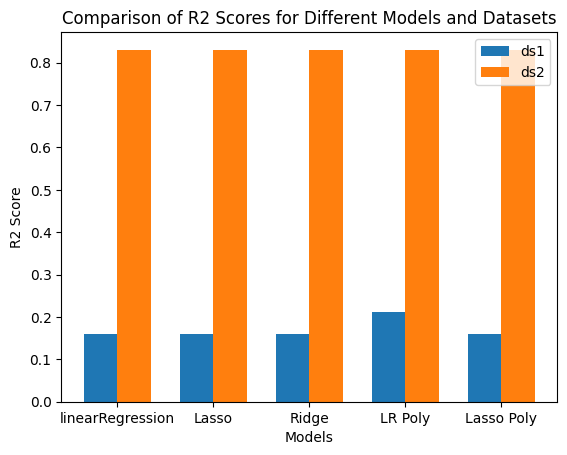

In [36]:
logger.plot_results()